# Floodscan

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px

from ochanticipy import create_country_config, CodAB

import utils

/Users/tdowning/.pyenv/versions/pa-aa-ner-flooding/lib/python3.11/site-packages/quantulum3/classifier.py:28: UserWarning: Classifier dependencies not installed. Run pip install quantulum3[classifier] to install them. The classifer helps to dissambiguate units.
  warnings.warn(


In [28]:
adm1s = ["Dosso", "Tillabéri"]
country_config = create_country_config("ner")
codab = CodAB(country_config=country_config)
codab = codab.load(admin_level=3)
codab = codab[codab["adm_01"].isin(adm1s)]
codab = codab.set_crs(4326)
# codab = codab.set_index(utils.ID_COL)
GAYA = "NER003006003"
F1 = "NER003006003"
F2 = "NER003006005"
F3 = "NER003006004"
F4 = "NER003004008"

In [5]:
# load raw data
ds = utils.read_raw_floodscan()
da = ds["SFED_AREA"]

In [52]:
# load processed data
df = utils.load_processed_floodscan()
df["mean_cell_log"] = np.log(df["mean_cell"]).replace(
    [np.inf, -np.inf], np.nan
)
df["mean_cell_rolling5"] = df.groupby(utils.ID_COL)["mean_cell"].transform(
    lambda x: x.rolling(5).mean()
)
df = df.merge(codab[[utils.ID_COL, "adm_03"]], on=utils.ID_COL)

/Users/tdowning/.pyenv/versions/pa-aa-ner-flooding/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



,rowcacode3,mean_cell,max_cell,min_cell,percentile_2,percentile_4,percentile_6,percentile_8,percentile_10,percentile_20,date,dayofseason,seasonyear,mean_cell_log,mean_cell_rolling5,adm_03
0,NER006005001,0.000067,0.0012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1998-01-12,224,1997,-9.615805,NaN,Bankilaré
1,NER006005001,0.000067,0.0012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1998-01-13,225,1997,-9.615805,NaN,Bankilaré
2,NER006005001,0.000061,0.0011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1998-01-14,226,1997,-9.702817,NaN,Bankilaré
3,NER006005001,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1998-01-15,227,1997,NaN,NaN,Bankilaré
4,NER006005001,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1998-01-16,228,1997,NaN,0.000039,Bankilaré
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780467,NER003002001,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-20,322,2021,NaN,0.000000,Dioundiou
780468,NER003002001,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-21,323,2021,NaN,0.000000,Dioundiou
780469,NER003002001,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-22,324,2021,NaN,0.000000,Dioundiou
780470,NER003002001,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-23,325,2021,NaN,0.000000,Dioundiou


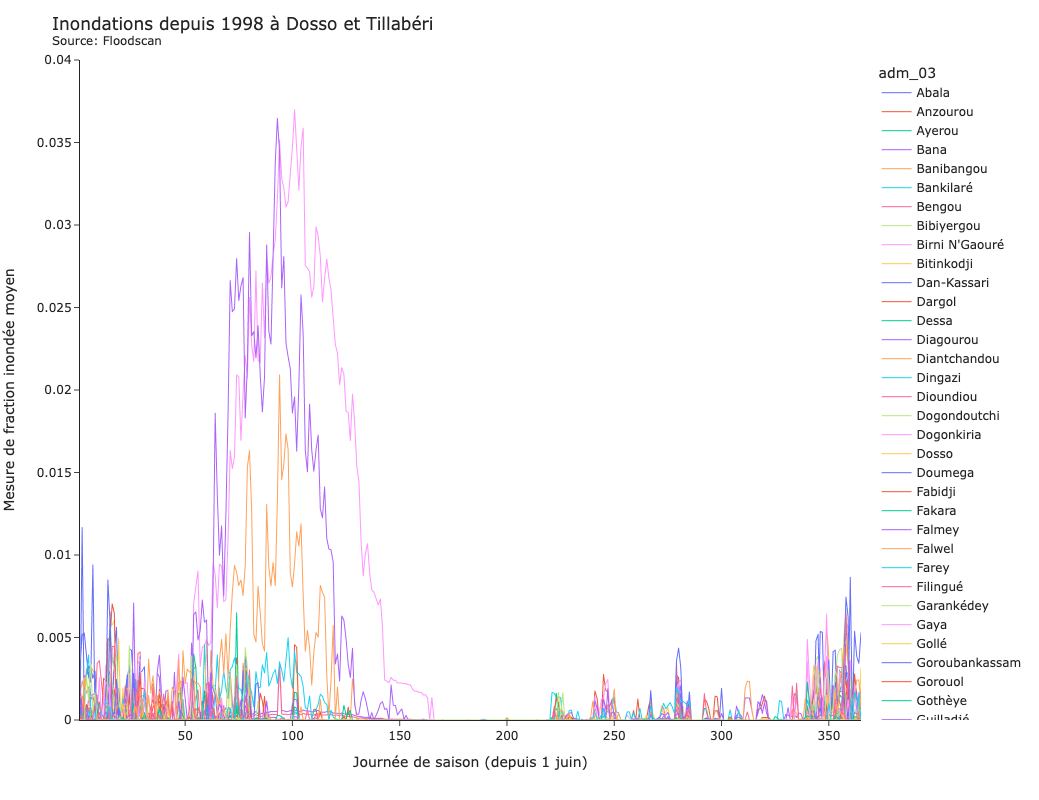

In [70]:
# plot average for all adm3
df_plot = (
    df.groupby(["adm_03", "dayofseason"]).mean(numeric_only=True).reset_index()
)
fig = px.line(df_plot, x="dayofseason", y="mean_cell", color="adm_03")
fig.update_traces(line_width=1)
fig.update_layout(
    template="simple_white",
    showlegend=True,
    title="Inondations depuis 1998 à Dosso et Tillabéri<br><sup>Source: Floodscan</sup>",
    height=800,
)
fig.update_yaxes(title="Mesure de fraction inondée moyen", range=[0, 0.04])
fig.update_xaxes(title="Journée de saison (depuis 1 juin)")
fig.show()

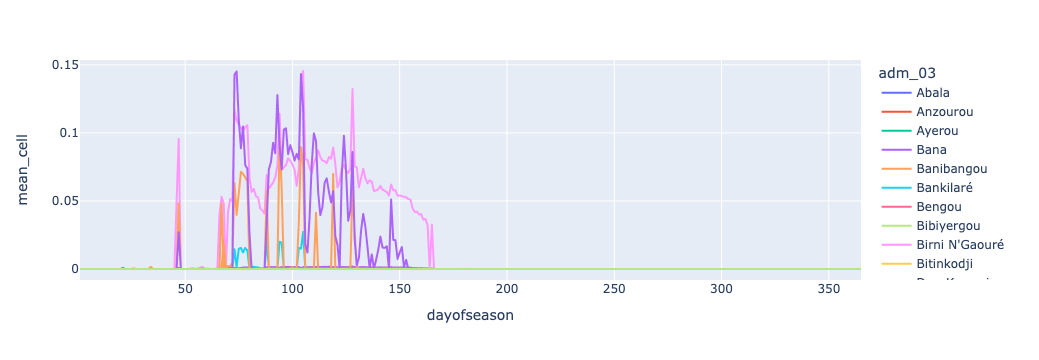

In [39]:
# plot by year for all adm3
years = [2020]
for year in years:
    df_plot = (
        df[df["seasonyear"] == year]
        .groupby(["adm_03", "dayofseason"])
        .mean(numeric_only=True)
        .reset_index()
    )
    px.line(df_plot, x="dayofseason", y="mean_cell", color="adm_03").show()

<Axes: >

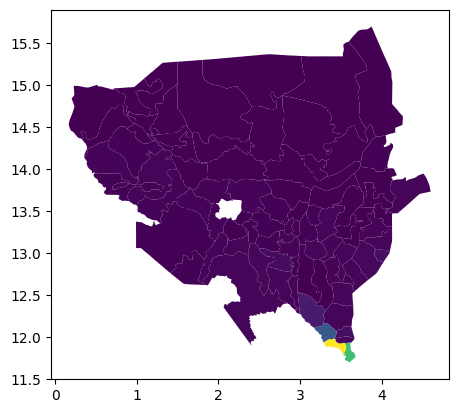

In [46]:
# plot by adm3, average over all years
dff = df[df["dayofseason"] < 200]
df_plot = codab.merge(
    dff.groupby(["adm_03"]).mean(numeric_only=True), on="adm_03"
)

df_plot.plot(column="mean_cell")

In [13]:
abn = utils.load_abn_niamey()
abn = utils.shift_to_floodseason(abn, use_index=True)
abn_peaks = utils.get_peak(abn, max_col="Water Level (cm)")

In [18]:
# compare overall
compare = df.merge(abn, left_on=["date"], right_index=True)
compare.corr(numeric_only=True)["Water Level (cm)"]
compare

,rowcacode3,mean_cell,max_cell,min_cell,percentile_2,percentile_4,percentile_6,percentile_8,percentile_10,percentile_20,date,dayofseason_x,seasonyear_x,mean_cell_log,mean_cell_rolling5,Water Level (cm),Discharges (m3/s),dayofseason_y,seasonyear_y
236778,NER003007002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005-01-01,213,2004,NaN,0.0,459.667,1367.244,213,2004
236779,NER003007001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005-01-01,213,2004,NaN,0.0,459.667,1367.244,213,2004
236780,NER003004007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005-01-01,213,2004,NaN,0.0,459.667,1367.244,213,2004
236781,NER003001008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005-01-01,213,2004,NaN,0.0,459.667,1367.244,213,2004
236782,NER003004003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005-01-01,213,2004,NaN,0.0,459.667,1367.244,213,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824812,NER003006004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-24,326,2021,NaN,0.0,200.500,108.500,326,2021
824813,NER003006001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-24,326,2021,NaN,0.0,200.500,108.500,326,2021
824814,NER003006005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-24,326,2021,NaN,0.0,200.500,108.500,326,2021
824815,NER003002001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-24,326,2021,NaN,0.0,200.500,108.500,326,2021


In [20]:
# plot for Gaya

px.line(
    compare[compare[utils.ID_COL] == GAYA],
    x="dayofseason_x",
    y="mean_cell",
    color="seasonyear_x",
).show()

px.line(
    compare[compare[utils.ID_COL] == GAYA],
    x="dayofseason_x",
    y="Water Level (cm)",
    color="seasonyear_x",
).show()

In [21]:
fs_cols = ["mean_cell", "min_cell", "max_cell", "mean_cell_log"]

for fs_col in fs_cols:
    df_peaks = utils.get_peak(df, max_col=fs_col)

    # check for correlations by adm3
    for adm3 in df_peaks[utils.ID_COL].unique():
        dff = df_peaks[df_peaks[utils.ID_COL] == adm3]
        fs_years = len(dff)
        dff = dff.merge(
            abn_peaks,
            left_on="seasonyear",
            right_on="seasonyear",
            suffixes=("_fs", "_abn"),
        )
        leadtime = (dff["dayofseason_abn"] - dff["dayofseason_fs"]).mean()
        corr = dff.drop(columns="seasonyear").corr(numeric_only=True)
        date_corr = corr.loc["dayofseason_fs", "dayofseason_abn"]
        level_corr = corr.loc[fs_col, "Water Level (cm)"]
        codab.loc[
            adm3,
            [
                "fs_years",
                f"{fs_col}_date_corr",
                f"{fs_col}_level_corr",
                f"{fs_col}_leadtime",
            ],
        ] = (
            fs_years,
            date_corr,
            level_corr,
            leadtime,
        )

In [325]:
codab[(codab["fs_years"] >= 10)].mean(numeric_only=True)

OBJECTID                    38.173077
ID                           0.000000
Shape_Leng                   1.562134
Shape_Area                   0.087469
fs_years                    15.396226
mean_cell_date_corr         -0.111299
mean_cell_level_corr         0.018286
mean_cell_leadtime          38.977802
min_cell_date_corr          -0.368496
min_cell_level_corr         -0.056112
min_cell_leadtime           31.762486
max_cell_date_corr          -0.121067
max_cell_level_corr          0.034617
max_cell_leadtime           38.814650
mean_cell_log_date_corr      0.117675
mean_cell_log_level_corr     0.019710
mean_cell_log_leadtime      43.439892
dtype: float64

,OBJECTID,ID,NOM_COM,adm_01,adm_02,adm_03,rowcacode1,rowcacode2,Shape_Leng,Shape_Area,...,mean_cell_leadtime,min_cell_date_corr,min_cell_level_corr,min_cell_leadtime,max_cell_date_corr,max_cell_level_corr,max_cell_leadtime,mean_cell_log_date_corr,mean_cell_log_level_corr,mean_cell_log_leadtime
rowcacode3,,,,,,,,,,,,,,,,,,,,,
NER006011001,11.0,0.0,DIAGOUROU,Tillabéri,Téra,Diagourou,NER006,NER006011,2.882009,0.106265,...,35.235294,-0.379332,NaN,33.058824,-0.359814,0.106510,35.352941,-0.411728,0.314977,67.625000
NER006007001,13.0,0.0,DARGOL,Tillabéri,Gothèye,Dargol,NER006,NER006007,3.550075,0.199869,...,48.941176,-0.405531,NaN,29.235294,-0.405956,0.132821,48.411765,-0.094959,0.078558,71.500000
NER006012004,14.0,0.0,KOURTEYE,Tillabéri,Tillabéri,Kourteye,NER006,NER006012,1.622147,0.106416,...,42.882353,-0.378472,NaN,32.941176,-0.411127,0.126377,42.882353,0.049567,-0.256760,67.857143
NER006013002,17.0,0.0,TORODI,Tillabéri,Torodi,Torodi,NER006,NER006013,3.622980,0.470524,...,37.000000,-0.377312,NaN,32.823529,-0.054644,0.211927,36.941176,0.324161,0.322551,38.545455
NER006013001,18.0,0.0,MAKALONDI,Tillabéri,Torodi,Makalondi,NER006,NER006013,1.643857,0.102067,...,23.823529,-0.377312,NaN,32.823529,-0.044377,0.260996,23.882353,0.737064,0.386724,14.285714
NER006010001,19.0,0.0,OURO GUELADJO,Tillabéri,Say,Ouro Guéladjo,NER006,NER006010,1.625923,0.071134,...,23.235294,-0.377312,NaN,32.823529,-0.063562,0.067587,22.647059,0.821344,0.020110,16.428571
NER006010003,20.0,0.0,TAMOU,Tillabéri,Say,Tamou,NER006,NER006010,4.842222,0.406458,...,37.235294,-0.377312,NaN,32.823529,-0.163382,0.326490,39.705882,-0.151325,0.074854,34.562500
NER003005001,22.0,0.0,FALMEY,Dosso,Falmey,Falmey,NER003,NER003005,1.813554,0.095237,...,52.529412,-0.406820,NaN,29.294118,-0.123469,0.005319,52.588235,-0.103716,0.137391,51.642857
NER003006003,24.0,0.0,GAYA,Dosso,Gaya,Gaya,NER003,NER003006,0.861500,0.023504,...,13.470588,-0.276216,0.169545,25.588235,-0.123880,0.617582,9.647059,-0.014403,0.505137,9.437500


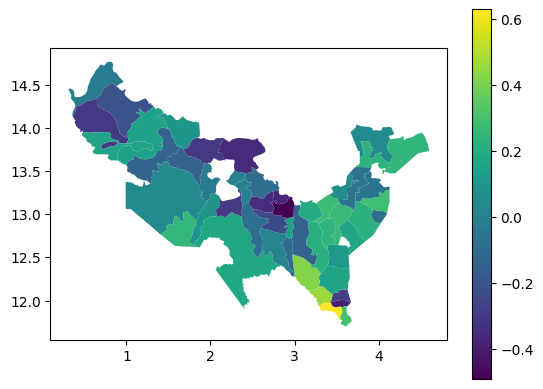

In [330]:
col = "mean_cell_level_corr"
codab[(codab["fs_years"] >= 10) & (codab[col] >= -10)].plot(
    column=col, legend=True
)
codab[(codab["fs_years"] >= 10) & (codab[col] >= 0)]

In [277]:
compare = abn.merge(df_date, left_index=True, right_index=True)
compare.corr()

,Water Level (cm),Discharges (m3/s),dayofseason_x,seasonyear_x,mean_cell,max_cell,min_cell,percentile_2,percentile_4,percentile_6,percentile_8,percentile_10,percentile_20,dayofseason_y,seasonyear_y,mean_cell_log
Water Level (cm),1.000000,0.977813,-0.186120,0.194258,0.156782,0.082152,0.201517,0.200183,0.198781,0.197315,0.195787,0.194202,0.184446,-0.186120,0.194258,0.328941
Discharges (m3/s),0.977813,1.000000,-0.157827,0.086314,0.164907,0.096506,0.196220,0.195022,0.193757,0.192429,0.191040,0.189595,0.180661,-0.157827,0.086314,0.313712
dayofseason_x,-0.186120,-0.157827,1.000000,-0.058324,-0.211854,-0.194049,-0.207658,-0.207089,-0.206447,-0.205734,-0.204951,-0.204105,-0.198651,1.000000,-0.058324,-0.172917
seasonyear_x,0.194258,0.086314,-0.058324,1.000000,0.163165,0.131868,0.172803,0.172509,0.172154,0.171738,0.171263,0.170731,0.166955,-0.058324,1.000000,0.261884
mean_cell,0.156782,0.164907,-0.211854,0.163165,1.000000,0.909207,0.788109,0.795376,0.802322,0.808943,0.815238,0.821227,0.850088,-0.211854,0.163165,0.538248
max_cell,0.082152,0.096506,-0.194049,0.131868,0.909207,1.000000,0.563440,0.570757,0.577835,0.584669,0.591255,0.597624,0.629396,-0.194049,0.131868,0.429899
min_cell,0.201517,0.196220,-0.207658,0.172803,0.788109,0.563440,1.000000,0.999817,0.999269,0.998364,0.997108,0.995508,0.981760,-0.207658,0.172803,0.499635
percentile_2,0.200183,0.195022,-0.207089,0.172509,0.795376,0.570757,0.999817,1.000000,0.999818,0.999276,0.998381,0.997139,0.985199,-0.207089,0.172509,0.500634
percentile_4,0.198781,0.193757,-0.206447,0.172154,0.802322,0.577835,0.999269,0.999818,1.000000,0.999820,0.999284,0.998399,0.988265,-0.206447,0.172154,0.501407
percentile_6,0.197315,0.192429,-0.205734,0.171738,0.808943,0.584669,0.998364,0.999276,0.999820,1.000000,0.999822,0.999293,0.990958,-0.205734,0.171738,0.501953


In [162]:
compare_peaks = abn_peaks.merge(
    df_peaks,
    left_on="seasonyear",
    right_on="seasonyear",
    suffixes=("_abn", "_fs"),
)
compare_peaks

,Water Level (cm),Discharges (m3/s),dayofseason_abn,seasonyear,rowcacode3,mean_cell_log,dayofseason_fs,date
0,497.0,1612.9,93,2005,NER003006002,-9.210340,99,2005-09-09
1,497.0,1612.9,93,2005,NER006010003,-10.985263,1,2005-06-03
2,497.0,1612.9,93,2005,NER003006001,-10.593931,38,2005-07-10
3,497.0,1612.9,93,2005,NER003008002,-11.849398,38,2005-07-10
4,497.0,1612.9,93,2005,NER003004008,-4.119282,27,2005-06-29
...,...,...,...,...,...,...,...,...
634,508.5,1314.5,86,2021,NER006010003,-9.815953,65,2021-08-06
635,508.5,1314.5,86,2021,NER003001002,-9.903288,76,2021-08-17
636,508.5,1314.5,86,2021,NER006008005,-11.715858,60,2021-08-01
637,508.5,1314.5,86,2021,NER003005002,-6.937815,65,2021-08-06


<Axes: xlabel='dayofseason_abn', ylabel='dayofseason_fs'>

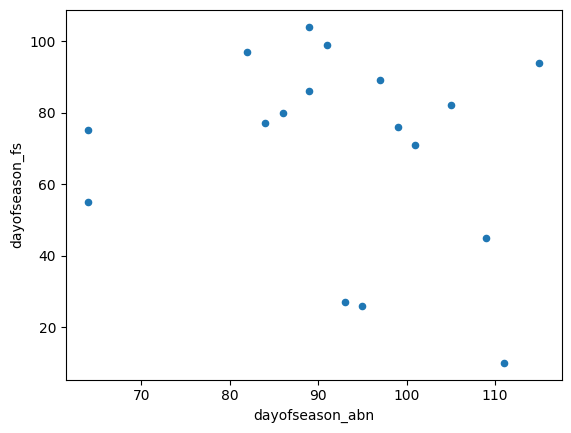

In [146]:
compare_peaks.plot.scatter(x="dayofseason_abn", y="dayofseason_fs")

In [62]:
norm = (compare - compare.min()) / (compare.max() - compare.min())

<Axes: >

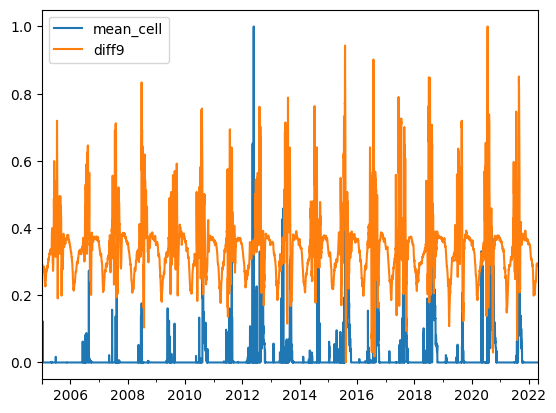

In [63]:
norm[["mean_cell", "diff9"]].plot()

,OBJECTID,ID,NOM_COM,adm_01,adm_02,adm_03,rowcacode1,rowcacode2,Shape_Leng,Shape_Area,...,min_cell,percentile_2,percentile_4,percentile_6,percentile_8,percentile_10,percentile_20,dayofseason,seasonyear,mean_cell_log
rowcacode3,,,,,,,,,,,,,,,,,,,,,
NER006005001,1.0,0.0,BANKILARE,Tillabéri,Bankilaré,Bankilaré,NER006,NER006005,2.300719,0.120116,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,184.088736,2009.249634,-9.180003
NER006011002,2.0,0.0,GOROUOL,Tillabéri,Téra,Gorouol,NER006,NER006011,3.121056,0.288477,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,184.088736,2009.249634,-9.473468
NER006011003,3.0,0.0,KOKOROU,Tillabéri,Téra,Kokorou,NER006,NER006011,2.414720,0.182311,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,184.088736,2009.249634,-8.444676
NER006011005,4.0,0.0,TERA,Tillabéri,Téra,Téra,NER006,NER006011,2.514908,0.173300,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,184.088736,2009.249634,-8.180922
NER006012003,5.0,0.0,DESSA,Tillabéri,Tillabéri,Dessa,NER006,NER006012,1.260870,0.042582,...,0.000000,5.412109e-09,1.082422e-08,1.623633e-08,2.164844e-08,2.706055e-08,4.970638e-08,184.088736,2009.249634,-7.154314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NER008001002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000007,7.319491e-06,7.319491e-06,7.319491e-06,7.319491e-06,7.319491e-06,7.319491e-06,184.088736,2009.249634,-6.548368
NER008001005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000001,2.129199e-06,3.226336e-06,4.323474e-06,5.420611e-06,6.517749e-06,1.200344e-05,184.088736,2009.249634,-6.713927
NER008001004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000004,5.732461e-06,7.796331e-06,9.860201e-06,1.192407e-05,1.398794e-05,2.430729e-05,184.088736,2009.249634,-7.495961


<Axes: >

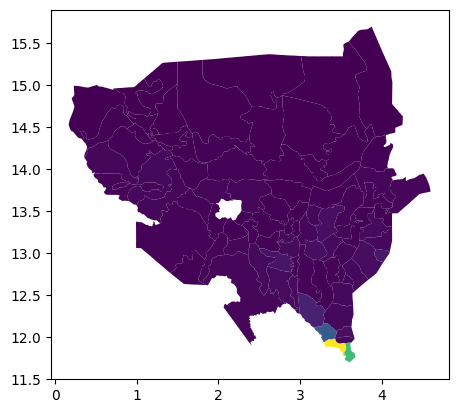

In [332]:
date = "2020-06-01"

codab_plot = codab.merge(df_adm3, left_index=True, right_on=utils.ID_COL)
display(codab_plot)
codab_plot.plot(column="mean_cell")

In [128]:
df.describe()

,mean_cell,max_cell,min_cell,percentile_2,percentile_4,percentile_6,percentile_8,percentile_10,percentile_20,date
count,33306.000000,33306.000000,33306.000000,33306.000000,33306.000000,33306.000000,33306.000000,33306.000000,33306.000000,34038
mean,0.000375,0.001119,0.000121,0.000121,0.000121,0.000122,0.000122,0.000122,0.000123,2020-11-30 12:00:00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-06-01 00:00:00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-08-31 00:00:00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-11-30 12:00:00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-03-02 00:00:00
max,0.145495,0.376778,0.145200,0.145200,0.145200,0.145200,0.145200,0.145200,0.145200,2021-06-01 00:00:00
std,0.005267,0.016012,0.003160,0.003160,0.003160,0.003160,0.003161,0.003161,0.003164,NaN


In [75]:
ds

<xarray.Dataset>
Dimensions:        (time: 8869, lat: 1080, lon: 1080)
Coordinates:
  * time           (time) datetime64[ns] 1998-01-12 1998-01-13 ... 2022-04-24
  * lat            (lat) float64 39.96 39.87 39.79 ... -49.79 -49.88 -49.96
  * lon            (lon) float64 -29.96 -29.88 -29.79 ... 59.79 59.88 59.96
Data variables:
    crs            int8 ...
    SFED_AREA      (lat, lon, time) float32 ...
    NDT_SFED_AREA  (lat, lon, time) float32 ...
    LWMASK_AREA    (lat, lon) float32 ...

In [1]:
da = ds["SFED_AREA"]
da = da.sel(time=date)
da = da.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
da = da.rio.write_crs(4326)
da = da.rio.clip(codab["geometry"], all_touched=True)

NameError: name 'ds' is not defined

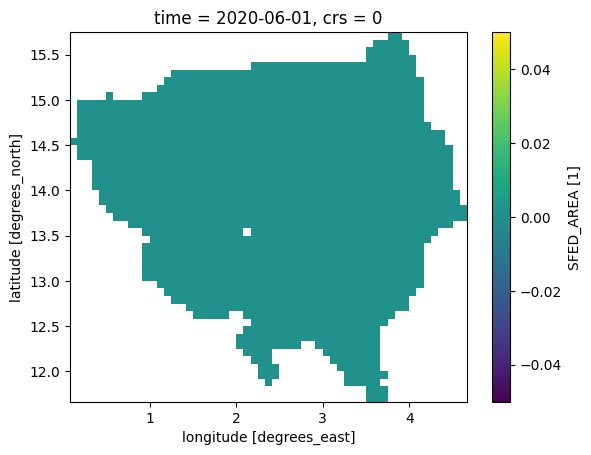

In [335]:
da.plot()